# **Spaceship Titanic**

# **Project Description**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good. The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension! To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

# **Goals**

Get highest classification accuracy score calculated by percentage of predicted labels for transported passengers

# **1.Reading libraries**

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# **2.Reading data**

Because data size is acceptable for memory capacity we're reading entire data from csv to DataFrame.

In [2]:
TRAIN_DATA_PATH = 'data/train.csv'
TEST_DATA_PATH = 'data/test.csv'

In [3]:
train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

# **3.EDA**

**Data Field Descriptions**

```PassengerId``` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.

```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.

```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

```Cabin``` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for Port or `S` for Starboard.

```Destination``` - The planet the passenger will be debarking to.

```Age``` - The age of the passenger.

```VIP``` - Whether the passenger has paid for special VIP service during the voyage.

```RoomService```, ```FoodCourt```, ```ShoppingMall```, ```Spa```, ```VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

```Name``` - The first and last names of the passenger.

```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Few steps before we start data analysis**

As was mentioned above each ```PassengerId``` takes the form `gggg_pp`, ```Cabin``` takes the form `deck/num/side` and ```Name``` contains first and last name my first step will be creating new columns from those features.

In [4]:
temp = train.copy()

In [5]:
def split_passenger_id(df):
    df[['Group', 'pp']] = df.PassengerId.str.split('_', expand=True)
    df.drop(columns='PassengerId',axis=1, inplace=True)
    return df

In [6]:
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df.Cabin.str.split('/', expand=True)
    df.drop(columns='Cabin',axis=1, inplace=True)
    return df

In [7]:
def split_name(df):
    df[['FirstName', 'LastName']] = df.Name.str.split(' ', expand=True)
    df.drop(columns='Name',axis=1, inplace=True)
    return df

In [8]:
temp = (temp
        .pipe(split_passenger_id)
        .pipe(split_cabin)
        .pipe(split_name)
        )

In [9]:
CATEGORICAL_FEATURES = temp.select_dtypes(exclude='number').drop(['FirstName','Group', 'pp', 'Num', 'LastName'], axis=1)
NUMERICAL_FEATURES = temp.select_dtypes(include='number')

In [10]:
CATEGORICAL_FEATURES

,HomePlanet,CryoSleep,Destination,VIP,Transported,Deck,Side
0,Europa,False,TRAPPIST-1e,False,False,B,P
1,Earth,False,TRAPPIST-1e,False,True,F,S
2,Europa,False,TRAPPIST-1e,True,False,A,S
3,Europa,False,TRAPPIST-1e,False,False,A,S
4,Earth,False,TRAPPIST-1e,False,True,F,S
...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,True,False,A,P
8689,Earth,True,PSO J318.5-22,False,False,G,S
8690,Earth,False,TRAPPIST-1e,False,True,G,S
8691,Europa,False,55 Cancri e,False,False,E,S


## **3.1 Background information**

In [11]:
def get_number_of_null_cells_in_row(df):
    return train.isnull().sum(axis=1).value_counts()

In [12]:
temp

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,Altark,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,Solam,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276,01,A,98,P,Gravior,Noxnuther
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278,01,G,1499,S,Kurta,Mondalley
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279,01,G,1500,S,Fayey,Connon
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280,01,E,608,S,Celeon,Hontichre


In [13]:
print(f"The number of rows in train data is {temp.shape[0]}, and the number of columns is {temp.shape[1]}")

The number of rows in train data is 8693, and the number of columns is 18


In [14]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Group         8693 non-null   object 
 12  pp            8693 non-null   object 
 13  Deck          8494 non-null   object 
 14  Num           8494 non-null   object 
 15  Side          8494 non-null   object 
 16  FirstName     8493 non-null   object 
 17  LastName      8493 non-null   object 
dtypes: bool(1), float64(6), obje

In [15]:
temp.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [16]:
temp.isna().sum().head(20)

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Group             0
pp                0
Deck            199
Num             199
Side            199
FirstName       200
LastName        200
dtype: int64

In [17]:
get_number_of_null_cells_in_row(temp)

0    6606
1    1867
2     203
3      17
dtype: int64

Approximately ~25% rows include null values that must be filled in.

<AxesSubplot: ylabel='Transported'>

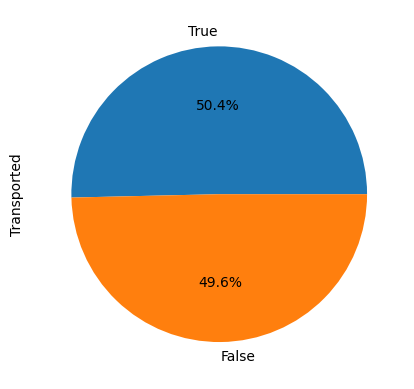

In [18]:
temp['Transported'].value_counts().plot(kind='pie', autopct='%1.1f%%')

As we can see train dataset is almost perfectly balanced.

### **3.2 Age --> Other**

In [19]:
temp

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,Altark,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,Solam,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276,01,A,98,P,Gravior,Noxnuther
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278,01,G,1499,S,Kurta,Mondalley
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279,01,G,1500,S,Fayey,Connon
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280,01,E,608,S,Celeon,Hontichre


AttributeError: 'numpy.ndarray' object has no attribute 'set_ylabel'

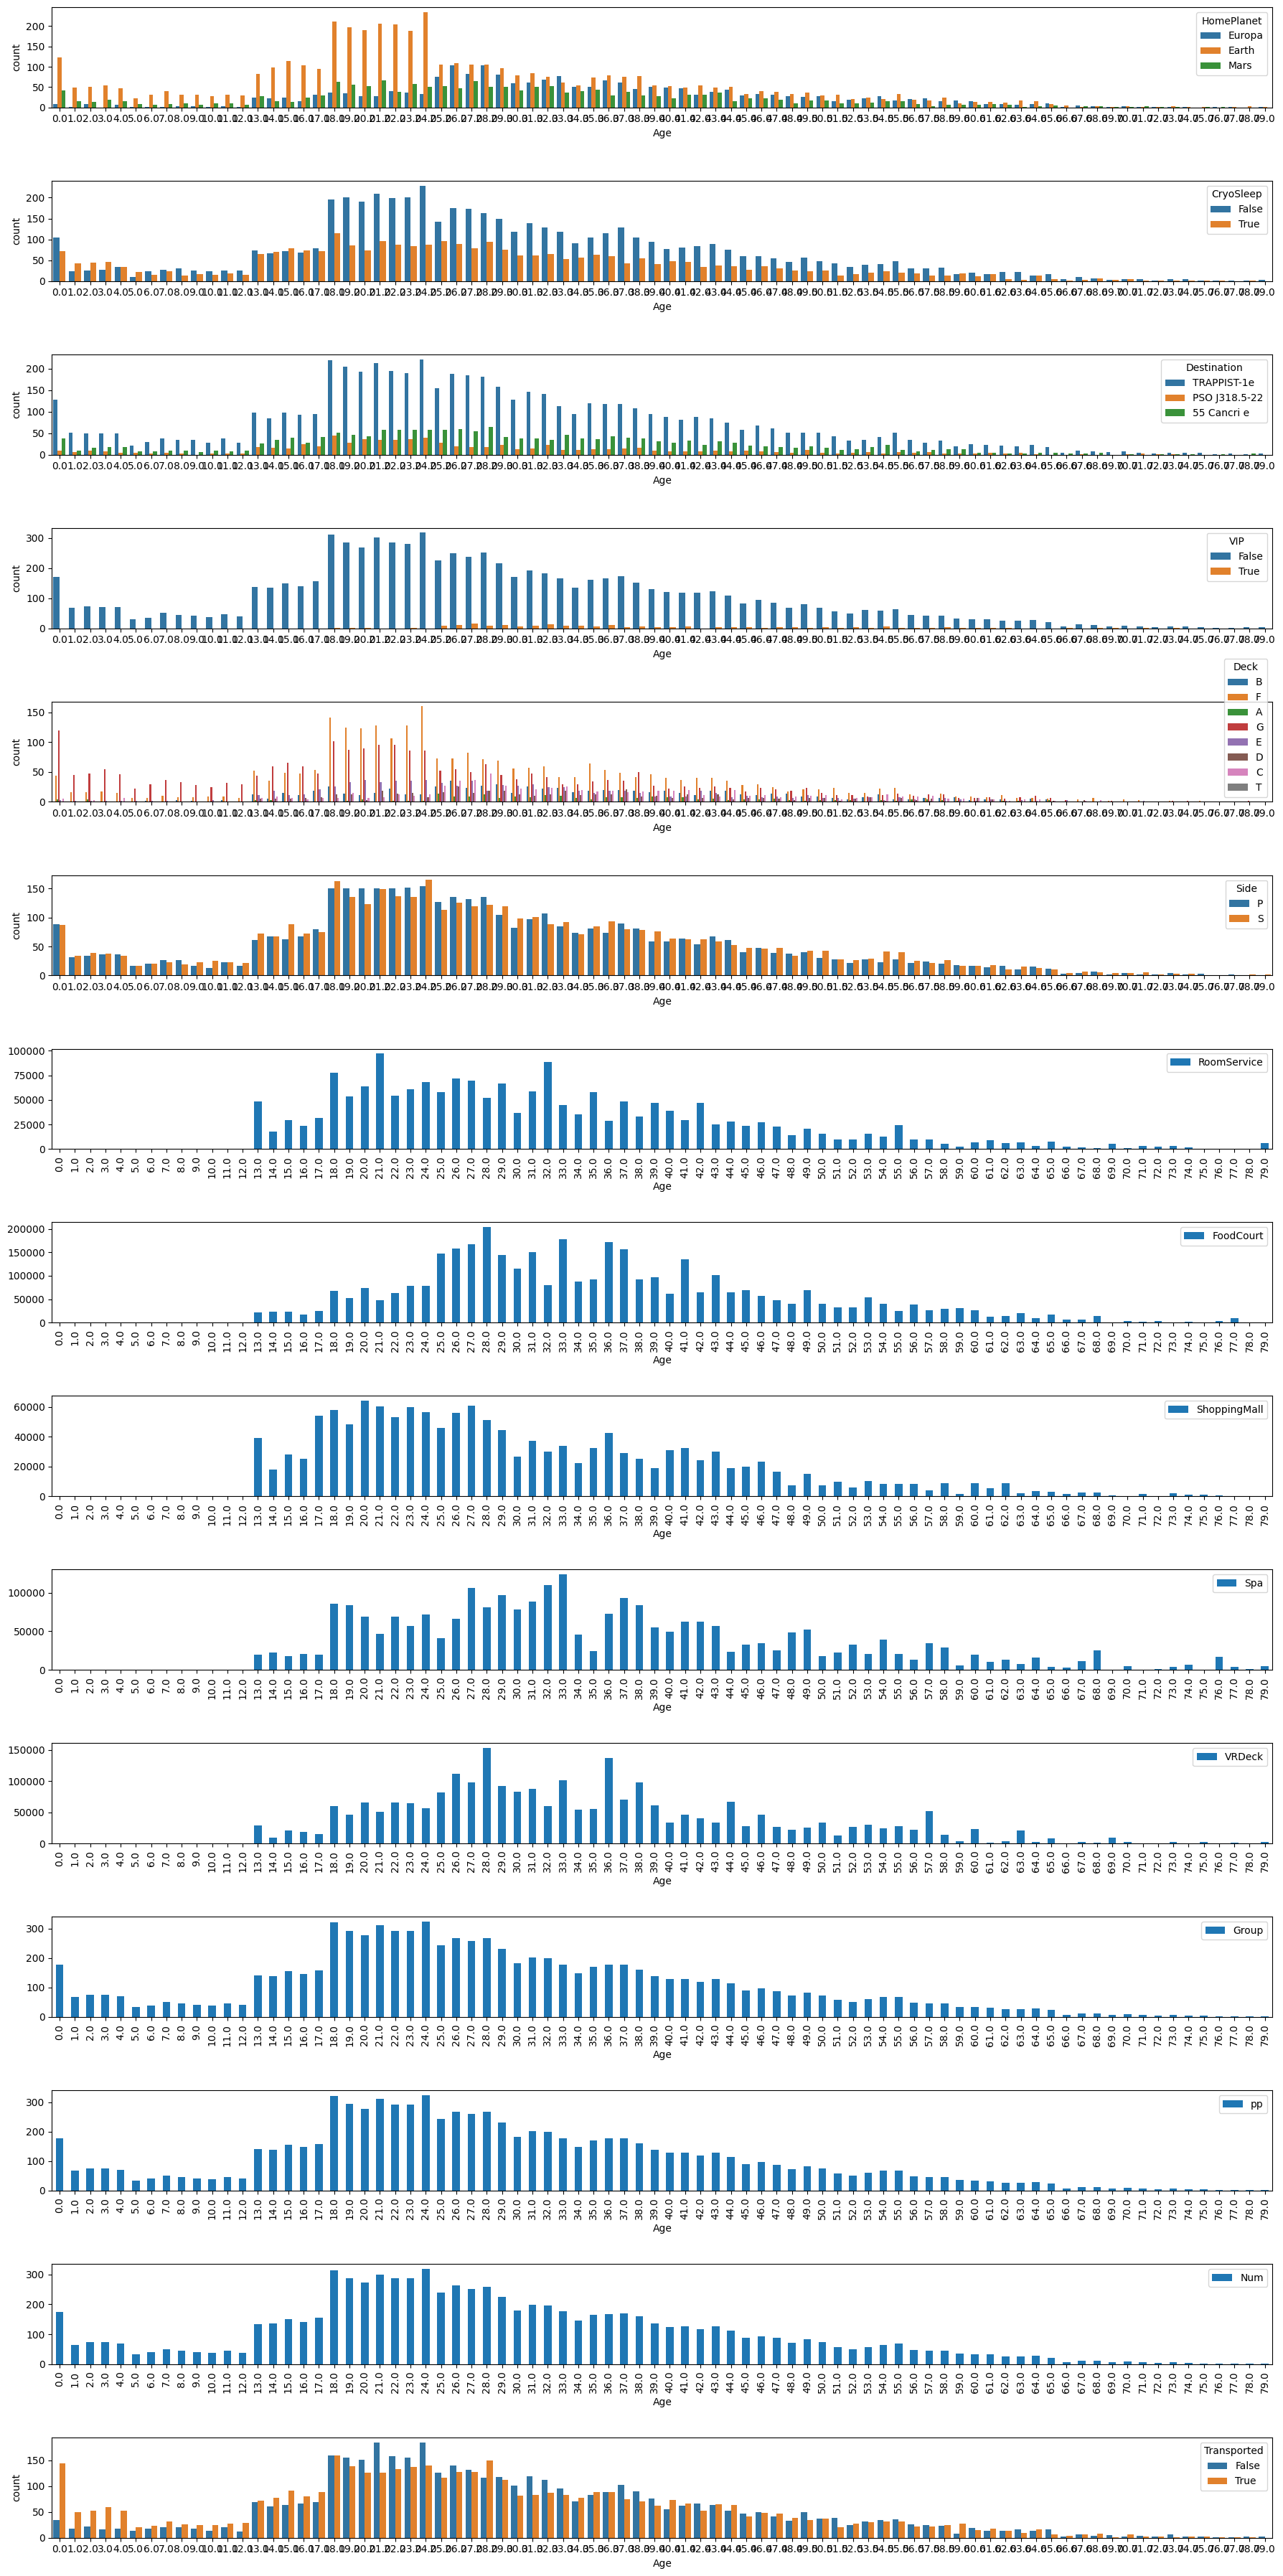

In [28]:
fig, ax = plt.subplots(15,figsize=(18,36))
sns.countplot(x='Age',hue='Transported',data=temp, ax=ax[14])
sns.countplot(x='Age',hue='HomePlanet',data=temp, ax=ax[0])
sns.countplot(x='Age',hue='CryoSleep',data=temp, ax=ax[1])
sns.countplot(x='Age',hue='Destination',data=temp, ax=ax[2])
sns.countplot(x='Age',hue='VIP',data=temp, ax=ax[3])
sns.countplot(x='Age',hue='Deck',data=temp, ax=ax[4])
sns.countplot(x='Age',hue='Side',data=temp, ax=ax[5])

temp.groupby('Age')['RoomService'].sum().plot(kind='bar', ax=ax[6], legend=True)
temp.groupby('Age')['FoodCourt'].sum().plot(kind='bar', ax=ax[7], legend=True)
temp.groupby('Age')['ShoppingMall'].sum().plot(kind='bar', ax=ax[8], legend=True)
temp.groupby('Age')['Spa'].sum().plot(kind='bar', ax=ax[9], legend=True)
temp.groupby('Age')['VRDeck'].sum().plot(kind='bar', ax=ax[10], legend=True)
temp.groupby('Age')['Group'].count().plot(kind='bar', ax=ax[11], legend=True)
temp.groupby('Age')['pp'].count().plot(kind='bar', ax=ax[12], legend=True)
temp.groupby('Age')['Num'].count().plot(kind='bar', ax=ax[13], legend=True)
fig.tight_layout()
ax.set_ylabel('count')
plt.show

Age is a continuous feature were necessery is discretization which I do grouping some ages basing on visualization above.<br>
Groups:<br>
0 - age equal 0 many unborns/newborns was transported it might have impact for future training. <br>
1 - age 1-4 high transportation ratio <br>
2 - age 5-12 low count of persons in those age group i compare to other<br>
3 - age 13-17 the first group in which expenses appear<br>
4 - age 18-24 up to 24 age old only 4 VIP exist<br>
5 - age 25-65 others<br>
6 - age 66- count of persons above 66 years old is highly decrased

In [21]:
def group_age(df):
    df['Age'] = pd.cut(df['Age'], bins=[0,1,5,13,18,25,66,110], labels=[0,1,2,3,4,5,6], right=False)
    return df

### **3.3 HomePlanet --> other**

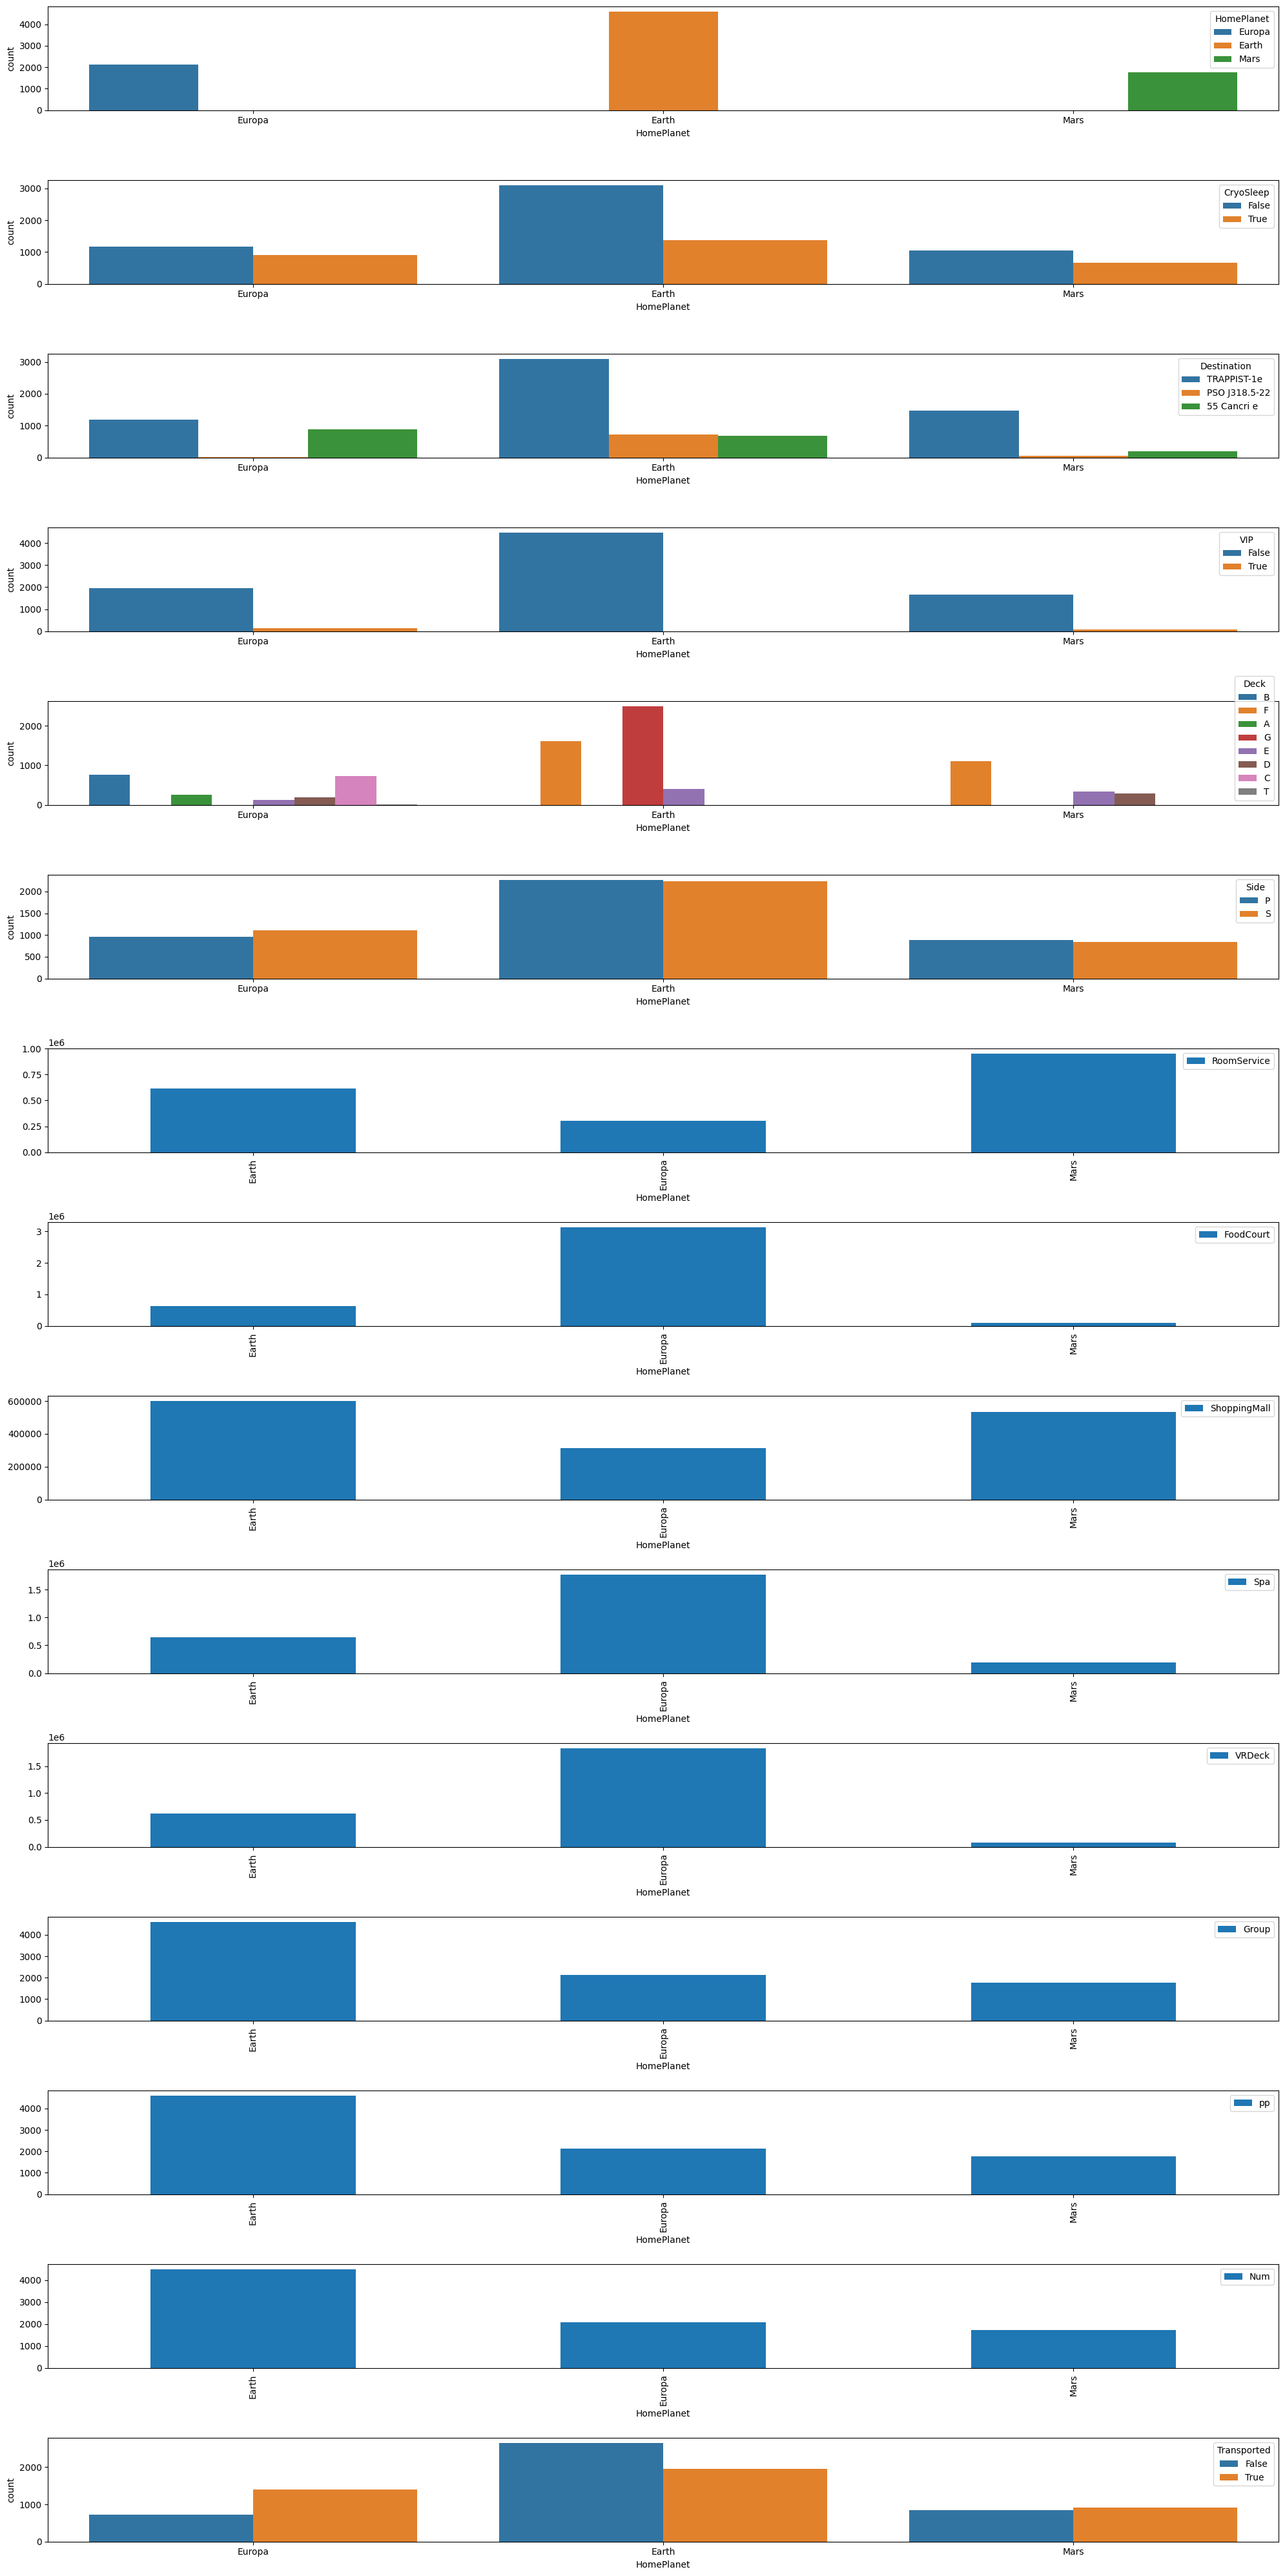

In [31]:
fig, ax = plt.subplots(15,figsize=(20,40))
sns.countplot(x='HomePlanet',hue='Transported',data=temp, ax=ax[14])
sns.countplot(x='HomePlanet',hue='HomePlanet',data=temp, ax=ax[0])
sns.countplot(x='HomePlanet',hue='CryoSleep',data=temp, ax=ax[1])
sns.countplot(x='HomePlanet',hue='Destination',data=temp, ax=ax[2])
sns.countplot(x='HomePlanet',hue='VIP',data=temp, ax=ax[3])
sns.countplot(x='HomePlanet',hue='Deck',data=temp, ax=ax[4])
sns.countplot(x='HomePlanet',hue='Side',data=temp, ax=ax[5])

temp.groupby('HomePlanet')['RoomService'].sum().plot(kind='bar', ax=ax[6], legend=True)
temp.groupby('HomePlanet')['FoodCourt'].sum().plot(kind='bar', ax=ax[7], legend=True)
temp.groupby('HomePlanet')['ShoppingMall'].sum().plot(kind='bar', ax=ax[8], legend=True)
temp.groupby('HomePlanet')['Spa'].sum().plot(kind='bar', ax=ax[9], legend=True)
temp.groupby('HomePlanet')['VRDeck'].sum().plot(kind='bar', ax=ax[10], legend=True)
temp.groupby('HomePlanet')['Group'].count().plot(kind='bar', ax=ax[11], legend=True)
temp.groupby('HomePlanet')['pp'].count().plot(kind='bar', ax=ax[12], legend=True)
temp.groupby('HomePlanet')['Num'].count().plot(kind='bar', ax=ax[13], legend=True)
fig.tight_layout()
plt.show()

In [36]:
temp[(temp.VIP == True) & (temp.HomePlanet == 'Earth')]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName


In [37]:
temp[(temp.Destination == 'PSO J318.5-22') & (temp.HomePlanet == 'Europa')]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
356,Europa,False,PSO J318.5-22,27.0,True,69.0,5728.0,0.0,0.0,987.0,True,0391,01,C,9,P,Dabik,Cowsearney
1217,Europa,True,PSO J318.5-22,30.0,False,0.0,0.0,0.0,0.0,0.0,True,1294,02,A,14,S,Chamak,Plegred
1448,Europa,False,PSO J318.5-22,25.0,True,0.0,7069.0,0.0,45.0,282.0,True,1529,01,A,16,S,Almino,Slable
2218,Europa,True,PSO J318.5-22,32.0,False,0.0,0.0,0.0,0.0,0.0,True,2377,01,C,83,P,Alark,Noxiong
2520,Europa,True,PSO J318.5-22,29.0,False,0.0,0.0,0.0,0.0,0.0,True,2707,02,B,103,S,Misa,Belstrut
2901,Europa,False,PSO J318.5-22,62.0,True,0.0,4513.0,0.0,85.0,1437.0,True,3134,01,C,119,S,Enifik,Clughted
4275,Europa,False,PSO J318.5-22,55.0,True,0.0,102.0,0.0,278.0,5353.0,False,4553,01,C,143,P,Auvam,Watuald
4336,Europa,False,PSO J318.5-22,34.0,True,0.0,NaN,21.0,7.0,16.0,True,4623,01,C,146,P,Sadrix,Repumparte
5714,Europa,False,PSO J318.5-22,29.0,True,3.0,1849.0,0.0,3104.0,1652.0,False,6055,01,C,185,P,Mino,Prefule
6780,Europa,True,PSO J318.5-22,32.0,False,0.0,0.0,0.0,0.0,0.0,True,7159,01,C,263,S,Alrairk,Perable


In [44]:
temp.groupby('HomePlanet')['Deck'].unique()

HomePlanet
Earth              [F, G, nan, E]
Europa    [B, A, C, D, nan, E, T]
Mars               [F, D, E, nan]
Name: Deck, dtype: object

# **4. Data Pre-processing**

In [ ]:
train_test = pd.concat([train, test])

In [ ]:
train_test = (train_test
              .pipe(split_cabin)
              .pipe(split_name)
            .pipe(split_passenger_id)
              )

In [ ]:
EXPENSES_COLUMNS = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [ ]:
train_test = train_test.loc[:,EXPENSES_COLUMNS]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

In [ ]:
temp['CryoSleep'].isnull().sum()

In [ ]:
train_test['CryoSleep'].isnull()

In [ ]:
#ProfileReport(train, title='Spaceship Titanic').to_file('Spaceship_Titanic.html')